In [1]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sn
import pandas as pd
import numpy as np

#### 1. Load datasets

In [2]:
# dataset_name = 'abalone'
# perc = 1

# df_train = pd.read_csv(f'../datasets/{dataset_name}/regular/{dataset_name}_train_perc{perc}.csv')
# df_test = pd.read_csv(f'../datasets/{dataset_name}/regular/{dataset_name}_test.csv')
# df_val = pd.read_csv(f'../datasets/{dataset_name}/regular/{dataset_name}_val.csv')

# n_classes = len(set(df_train[df_train.columns[-1]]))
# print(n_classes)

In [27]:
dataset_name = 'abalone'
perc = 1

df_train = pd.read_csv(f'../datasets/{dataset_name}/extreme/{perc}/{dataset_name}_train_perc{perc}.csv')
df_test = pd.read_csv(f'../datasets/{dataset_name}/extreme/{perc}/{dataset_name}_test_perc{perc}.csv')

n_classes = len(set(df_train[df_train.columns[-1]]))
print(n_classes)
len(set(df_test[df_test.columns[-1]]))

23


23

In [28]:
if any(isinstance(df_train[x][0], str) for x in df_train.columns):
    ### ----- IF DATA IS CATEGORICAL ----- ##
    print("Categorical data - let's one hot encode the features!\n")
    print("Number of features before:", len(df_train.columns))
    df_train['set type'] = 'train'
    df_test['set type'] = 'test'
#     df_val['set type'] = 'val'

#     total_df = pd.concat([df_train, df_test, df_val])
    total_df = pd.concat([df_train, df_test])

    total_df = pd.get_dummies(total_df, columns=total_df.columns[:-2])
    
    cols = list(total_df.columns)
    cols = cols[1:] + cols[:1]
    total_df = total_df[cols]
    
    df_train = total_df[total_df['set type'] == 'train']
    df_test = total_df[total_df['set type'] == 'test']
#     df_val = total_df[total_df['set type'] == 'val']

    del df_train['set type']
    del df_test['set type']
#     del df_val['set type']
    
    print("Number of features after one hot encoding:", len(df_train.columns))

In [29]:
target_name = df_train.columns[-1]
X_train, y_train = df_train.drop([target_name], axis='columns'), df_train[target_name]
X_test, y_test = df_test.drop([target_name], axis='columns'), df_test[target_name]
# X_val, y_val = df_val.drop([target_name], axis='columns'), df_val[target_name]

In [30]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# y_val = le.fit_transform(y_val)

#### 2. Train data using the randomforest classifier

In [31]:
params = {
          "objective" : "multiclass",
          "num_class" : n_classes,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

On validation set

In [32]:
lgtrain, lgval = lgb.Dataset(X_train, y_train), lgb.Dataset(X_test, y_test)
lgbmodel = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)

/data/lecraizer/envs/venv/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/data/lecraizer/envs/venv/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 1.76649	valid_1's multi_logloss: 2.36222
Early stopping, best iteration is:
[259]	training's multi_logloss: 1.55069	valid_1's multi_logloss: 2.34657


#### 3. Evaluate test set with confusion matrix

In [33]:
y_pred = np.argmax(lgbmodel.predict(X_test),axis=1)
y_true = y_test
accuracy_score(y_true, y_pred)

0.22489082969432314

#### 4. Plot results

Text(33.0, 0.5, 'true')

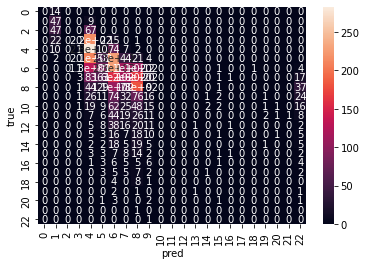

In [34]:
cm = confusion_matrix(y_test, y_pred)

sn.heatmap(cm, annot=True)
plt.xlabel('pred')
plt.ylabel('true')